In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/Kannada-MNIST/Dig-MNIST.csv
/kaggle/input/Kannada-MNIST/train.csv
/kaggle/input/Kannada-MNIST/sample_submission.csv
/kaggle/input/Kannada-MNIST/test.csv


In [2]:
data_train = pd.read_csv("../input/Kannada-MNIST/train.csv")
data_test = pd.read_csv("../input/Kannada-MNIST/test.csv")
data_submission = pd.read_csv("../input/Kannada-MNIST/sample_submission.csv")

In [3]:
#Visualize some images
X = data_train.iloc[:,1:]
y = data_train.iloc[:,0]
X = np.asarray(X)
y = np.asarray(y)

The convolution con2d in  tensorflow requires a 4D tensor [Batch widht height channel]

In [4]:
X = X.reshape(-1,28,28,1) #reshaping the images into a 4d vector iin order to  process the convolution

Splitting the data into 70:30 , where 70 goes for training and 30 goes for test or validation

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)


Let us now see the size of the training data 

In [6]:
X_train.shape

(42000, 28, 28, 1)

using immport to_catogorical we can convert the integer matrix to a binary matrix

In [7]:
from keras.utils.np_utils import to_categorical
X_train = X_train.reshape((42000, 28, 28, 1))
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape((18000, 28, 28, 1))
X_test = X_test.astype('float32') / 255
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Using TensorFlow backend.


With this we jump on to creating a Convolutional Neural Network, by importiing a dense layer, 2d connvolution, Maxpooling, flatten, a sequential ie. fully connected feedforward network.

In [8]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras import Sequential
from keras import layers
from keras import models

A sequential model is a fully connected feedforward neural network , adding a 2d convolution layer with kernal size of 3*3, filter =36
maxpooling poolsize of 2*2
and so on

In [9]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape= (28,28,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
#model.add(layers.Conv2D(128, (3,3), activation='relu'))
#model.add(layers.MaxPooling2D((2,2)))
#model.add(layers.Conv2D(256, (3,3), activation='relu'))
#model.add(layers.MaxPooling2D((2,2)))
#Flaten the 3D conv-net to 1D for the Dense layers
model.add(layers.Flatten())
#model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

The whole model that we prepred above is summarized below

In [10]:

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

In [11]:
from keras.preprocessing.image import ImageDataGenerator

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range= 10,#10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.05,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,#0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)      


In [13]:
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau

In [14]:
optimizer=RMSprop(lr=0.001,rho=0.9,decay=0.0)

In [15]:
model.compile(optimizer= 'adam',#optimizer, 
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [16]:

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000001)

In [17]:

epochs=60 #40 #  #35
batch_size=32 #64

In [18]:

train_datagen = datagen.flow(X_train,
                             y_train, 
                             batch_size=batch_size)

In [19]:

# Fit the model
history = model.fit_generator(train_datagen,#datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, 
                              validation_data = (X_test,y_test),
                              verbose = 1, 
                              steps_per_epoch=X_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction])

Epoch 1/60
1312/1312 [==============================] - 30s 23ms/step - loss: 0.2247 - accuracy: 0.9273 - val_loss: 0.0382 - val_accuracy: 0.9882
Epoch 2/60
  10/1312 [..............................] - ETA: 23s - loss: 0.0787 - accuracy: 0.9688

/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1312/1312 [==============================] - 26s 20ms/step - loss: 0.0713 - accuracy: 0.9778 - val_loss: 0.0581 - val_accuracy: 0.9822
Epoch 3/60
1312/1312 [==============================] - 26s 20ms/step - loss: 0.0556 - accuracy: 0.9828 - val_loss: 0.0241 - val_accuracy: 0.9919
Epoch 4/60
1312/1312 [==============================] - 26s 20ms/step - loss: 0.0460 - accuracy: 0.9857 - val_loss: 0.0274 - val_accuracy: 0.9926
Epoch 5/60
1312/1312 [==============================] - 26s 20ms/step - loss: 0.0394 - accuracy: 0.9878 - val_loss: 0.0192 - val_accuracy: 0.9941
Epoch 6/60
1312/1312 [==============================] - 25s 19ms/step - loss: 0.0362 - accuracy: 0.9883 - val_loss: 0.0209 - val_accuracy: 0.9936
Epoch 7/60
1312/1312 [==============================] - 25s 19ms/step - loss: 0.0311 - accuracy: 0.9901 - val_loss: 0.0266 - val_accuracy: 0.9933
Epoch 8/60
1312/1312 [==============================] - 25s 19ms/step - loss: 0.0299 - accuracy: 0.9901 - val_loss: 0.0223 - val_accura

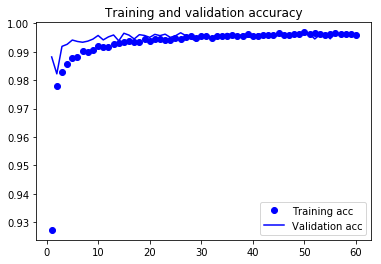

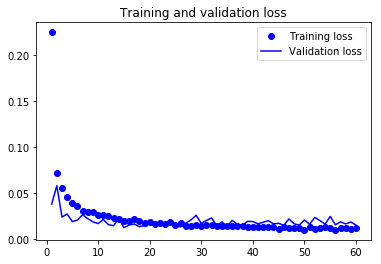

In [20]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [21]:
y_pre_test=model.predict(X_test)
y_pre_test=np.argmax(y_pre_test,axis=1)
y_test=np.argmax(y_test,axis=1)

In [22]:
from sklearn.metrics import confusion_matrix

In [23]:
conf=confusion_matrix(y_test,y_pre_test)
conf=pd.DataFrame(conf,index=range(0,10),columns=range(0,10))

In [24]:
conf

,0,1,2,3,4,5,6,7,8,9
0,1774,10,0,1,0,0,0,0,0,0
1,6,1827,0,1,0,0,0,0,0,0
2,2,0,1831,0,0,0,0,0,0,0
3,0,0,0,1776,1,0,0,8,0,0
4,0,1,0,0,1808,0,0,0,0,0
5,0,0,0,1,3,1766,0,0,0,0
6,0,0,0,0,0,0,1770,8,0,5
7,0,0,0,6,0,0,4,1832,0,0
8,0,0,0,0,0,0,0,0,1775,0
9,0,0,0,0,1,0,6,0,0,1777


In [25]:
test=pd.read_csv('../input/Kannada-MNIST/test.csv')

In [26]:
test_id=test.id

test=test.drop('id',axis=1)
test=test/255
test=test.values.reshape(-1,28,28,1)

In [27]:
test.shape

(5000, 28, 28, 1)

In [28]:
y_pre=model.predict(test)     ##making prediction
y_pre=np.argmax(y_pre,axis=1) ##changing the prediction intro labels

In [29]:
data_submission['label']=y_pre
data_submission.to_csv('submission.csv',index=False)

In [30]:
data_submission.head()

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7
